In [49]:
import numpy as np
import os
from scipy.stats import norm
import math
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
from scipy.optimize import fsolve, root
import datetime
import copy
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

## Fixed income functions

In [50]:
# curve data
os.chdir('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/data/')
EUSA = pd.read_excel('EUSA_data.xlsx')

# change dataframe layout
index = EUSA['Dates'].copy()
EUSA = pd.melt(EUSA.reset_index(),
               id_vars=['Dates'],
               value_vars=['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y'],
               var_name='Maturity', value_name='Spot rate').set_index(['Dates'])
EUSA.name = 'EUSA'

# convert strings to float
def maturity_convert(Maturity):
    if Maturity[-1] == 'M':
        MaturityInYear = float(Maturity[:-1]) / 12  # if 6M -> 6/12
    else:
        MaturityInYear = float(Maturity[:-1])       # if xY -> float(x)
    return MaturityInYear

EUSA['Maturity (years)'] = EUSA['Maturity'].apply(lambda x: maturity_convert(x))

# change % to decimal
EUSA['Spot rate (decimal)'] = EUSA['Spot rate'].apply(lambda x: x / 100)

# cubic spline interpolation
def cubspline_curve(date, T, df_curve):
    S = interp1d(df_curve['Maturity (years)'][str(date)], 
                 df_curve['Spot rate (decimal)'][str(date)], 
                 kind='cubic', 
                 fill_value='extrapolate')
    return S(T)

def disc_factor(date, T, curve = EUSA):
    
    rate = np.log(1 + cubspline_curve(date, T, curve))

    return np.exp(-rate * T)    # curve is cont. comp.

def forw_rate(date, T, tau, curve = EUSA):

    P_0_T = disc_factor(date, T, curve)
    P_0_T_tau = disc_factor(date, T+tau, curve)

    return 1 / tau * (P_0_T / P_0_T_tau - 1)

def payment_schedule(date, expiry, tenor, tau):
    unadj_dates = []
    adj_dates = []

    t_0 = pd.Timestamp(date).date()
    t_m = (t_0 + DateOffset(months=(expiry * 12)) + pd.tseries.offsets.BusinessDay(0)).date()
    t_n = (t_m + DateOffset(months=(tenor * 12))).date()    #unadjusted for business days
    t_m_copy = t_m

    delta_months = relativedelta(months=+(tau * 12))

    while t_m_copy < t_n:
        unadj_dates.append(t_m_copy)
        t_m_copy = t_m_copy + delta_months

    unadj_dates.append(t_m_copy)

    for date in unadj_dates:
        adj_dates.append((date + pd.tseries.offsets.BusinessDay(0)).date())
    
    return adj_dates

def coverage(date, expiry, tenor, tau):
    coverage = []
    dates = []

    adj_dates = payment_schedule(date, expiry, tenor, tau)
    t_0 = pd.Timestamp(date).date()
    dates_roll = expiry + tau

    for i in range(1, len(adj_dates)):
        coverage.append(1 / 360 * (
            360 * (adj_dates[i].year - adj_dates[i - 1].year)
            + 30 * (adj_dates[i].month - adj_dates[i - 1].month)
            + min(30, adj_dates[i].day) 
            - min(30, adj_dates[i - 1].day)
            )
        )
        dates.append(dates_roll)
        dates_roll = dates_roll + coverage[i - 1]

    # coverage[0] = coverage
    # coverage[1] = tidspunkt for betaling
    return coverage, dates

def swap_rate(date, expiry, tenor, tau_floating, tau_fixed, curve = EUSA):
    floating_leg = 0
    fixed_leg = 0

    floating_coverage, floating_dates = coverage(date, expiry, tenor, tau_floating)
    fixed_coverage, fixed_dates = coverage(date, expiry, tenor, tau_fixed)

    for i in range(len(floating_dates)):
        floating_leg = floating_leg + disc_factor(date, floating_dates[i], curve) * floating_coverage[i] * forw_rate(date, floating_dates[i] - floating_coverage[i], floating_coverage[i],  curve)

    for i in range(len(fixed_dates)):
        fixed_leg = fixed_leg + disc_factor(date, fixed_dates[i]) * fixed_coverage[i]

    return floating_leg / fixed_leg

def annuity_func(date, expiry, tenor, tau, curve = EUSA):
    ann = 0
    cov, dates = coverage(date, expiry, tenor, tau)
    for i in range(len(dates)):
        ann = ann + disc_factor(date, dates[i], curve) * cov[i]
    return ann

def bachelier(F, K, sigma_normal, date, expiry, tenor, tau, t = 0):
    d = (F - K) / (sigma_normal * np.sqrt(expiry - t))
    return annuity_func(date, expiry, tenor, tau) * ((F - K) * norm.cdf(d) + sigma_normal * np.sqrt(expiry - t) * norm.pdf(d))

## Payer swaption functions

In [51]:
def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

def char_func(u, T, theta, eta, z_0, lambd, b):
    v = 1/2 * (lambd * b)**2 * u * (u - 1)

    gamma = np.sqrt(theta**2 - 2 * eta**2 * v)
    A = 1 / eta**2 * theta * z_0 * (2 * np.log(2 * gamma / (theta + gamma - np.exp(-gamma * T)*(theta - gamma))) + (theta - gamma) * T)
    B = 2 * v * (1 - np.exp(-gamma * T)) / ((theta + gamma) * (1 - np.exp(-gamma * T)) + 2 * gamma * np.exp(-gamma * T))
    return np.exp(A + B * z_0)

def payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor):
    xmin = 0
    xmax = 2000
    int_points = 10000
    [u, wgt] = trap_integration(xmin, xmax, int_points)
    
    S_prime = b * S + (1 - b) * L
    K_prime = b * K + (1 - b) * L

    integrand = np.real((np.exp(-(1/2 + 1j * u) * np.log(K_prime / S_prime)) * char_func(1/2 + 1j * u, expiry, theta, eta, z_0, lambd, b)) / (u**2 + 1/4))
    integral = sum(wgt * integrand)

    annuity = annuity_func(date, expiry, tenor, tau_floating_leg, EUSA)

    return annuity / b * (S_prime - K_prime / np.pi * integral)

## Misc inputs

In [52]:
###############################
date = datetime.date(2023,9,18)
###############################

tau_floating = 0.5      # EUSA swaps are semi-annual
tau_floating_leg = 0.5
tau_fixed = 1           # fixed rates paid annually

z_0 = 1

## Load data

In [53]:
swaption_data = pd.read_excel('swaption_cube_23.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube_23.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube_23.xlsx').sheet_names[:int(number_of_grids)]

df_swaption_iv = []

for i in range(int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_23.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_iv.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

In [54]:
swaption_data = pd.read_excel('swaption_cube_23.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube_23.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube_23.xlsx').sheet_names[int(number_of_grids):]

df_swaption_strikes = []

for i in range(int(number_of_grids),2*int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_23.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_strikes.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

## Set up lists with strikes, swap rates, and prices

In [ ]:
swaption_expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])
swaption_tenor = np.array([1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 25, 30])

df_strike = []
df_swap_rate = []
df_price = []

for i in range(len(df_swaption_iv)): # grid loop
    [M,N] = df_swaption_iv[i].shape

    df_strike_i = df_swaption_iv[i].copy()
    df_swap_rate_i = df_swaption_iv[i].copy()
    df_price_i = df_swaption_iv[i].copy()

    for m in range(M): # expiry loop
        T = swaption_expiry[m]      

        for n in range(N): # tenor loop
            tenor = swaption_tenor[n]
            moneyness = float(df_swaption_strikes[i].name) / 10000  # convert from bps. to decimal

            K = df_swaption_strikes[i].iloc[m,n] / 100
            S = K - moneyness

            normal_vol = df_swaption_iv[i].iloc[m,n] / 10000   # convert from bps. to decimal
            
            df_strike_i.iloc[m,n] = K
            df_swap_rate_i.iloc[m,n] = S
            df_price_i.iloc[m,n] = bachelier(S, K, normal_vol, date, T, tenor, tau_floating, t = 0)  # bachelier price (since data uses normal vols)
    
    df_strike.append(pd.DataFrame(df_strike_i))
    df_swap_rate.append(pd.DataFrame(df_swap_rate_i))
    df_price.append(pd.DataFrame(df_price_i))

df_strike, df_swap_rate, df_price

## 10-year swap rate strips

In [56]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

tenor = 10

### 10-year tenor swaptions, market implied volatility

In [57]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

## Calibration 1: fixed parameters

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]

        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),(0.27, np.inf))

init_lambd = 0.25
init_b = 0.2
init_eta = 1.0
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strips))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [58]:
b =	0.17469232053426645
eta = 1.482754554571749
theta = 0.27000001
lambd =	0.3006760343614427

### Model implied volatilities

In [59]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_1 = []

for i in range(len(points)):

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    # print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
        
        # print("model price", payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor))
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        # print("bach price", bachelier(S, K, res, date, T, tenor, tau_floating, t = 0))

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_1.append(IV_i)

T =  2.0
97.44419718313117
96.67005713957111
95.89020401546277
95.10568394391643


KeyboardInterrupt: 

### Implied volatility plots: model vs. market

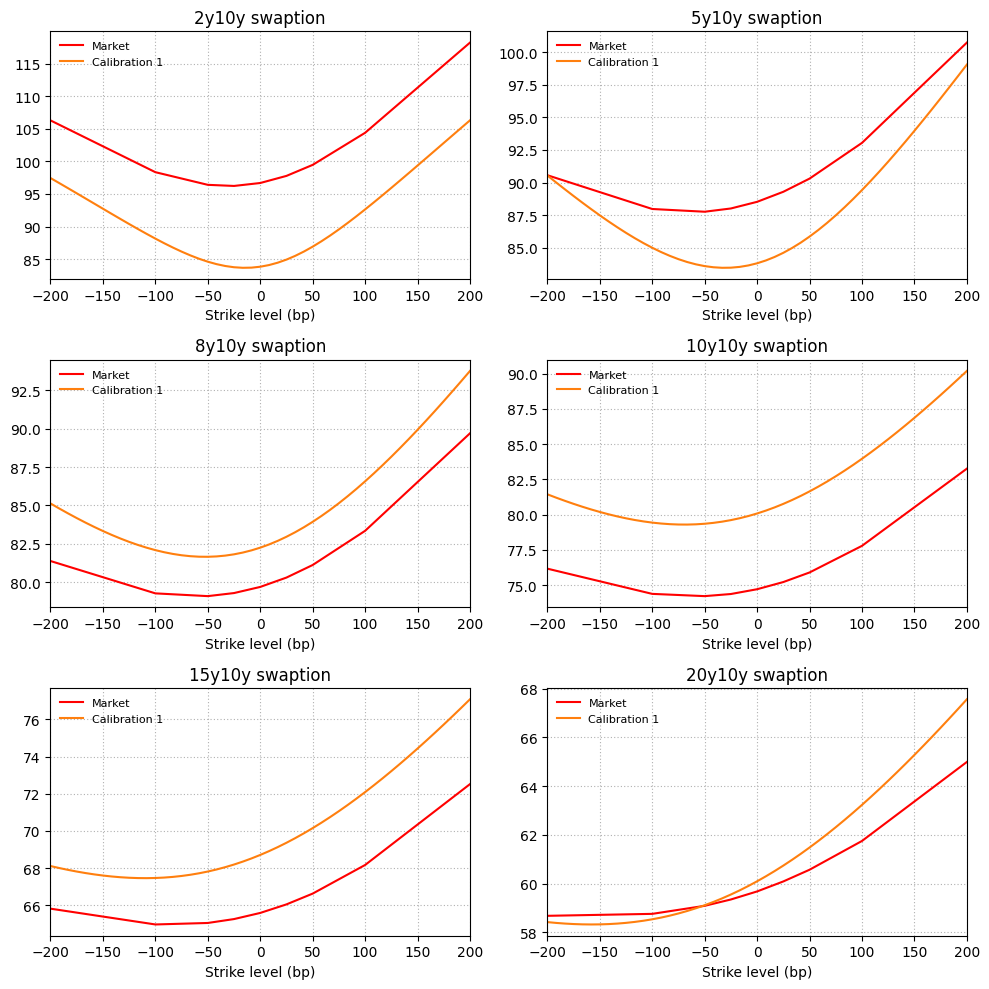

In [73]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]

IV_1_errors = []

for i in range(len(points)):

    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                    S-0/10000,
                    S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    # print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
        
        # print("model price", payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor))
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        # print("bach price", bachelier(S, K, res, date, T, tenor, tau_floating, t = 0))

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_1_errors.append(IV_i)

##### Market

In [62]:
expiries = ["3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [63]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_1_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 1']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 1"
3Mo,12.119979
6Mo,8.443247
9Mo,7.744046
1Yr,7.765196
2Yr,11.751711
3Yr,10.875426
4Yr,7.929053
5Yr,3.751542
6Yr,1.681298
7Yr,1.318490


Average root mean squared error = 5.484270449424027


## Calibration with constant parameters and $\lambda(t)$

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19])

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        lambd = lambdas[m]
        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), 
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
init_lambda_5 = 0.3
init_lambda_6 = 0.3
init_lambda_7 = 0.3
init_lambda_8 = 0.3
init_lambda_9 = 0.3
init_lambda_10 = 0.3
init_lambda_11 = 0.3
init_lambda_12 = 0.3
init_lambda_13 = 0.3
init_lambda_14 = 0.3
init_lambda_15 = 0.3
init_lambda_16 = 0.3
init_lambda_17 = 0.3
init_lambda_18 = 0.3
init_lambda_19 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4, init_lambda_5, init_lambda_6, init_lambda_7, init_lambda_8, init_lambda_9, init_lambda_10, init_lambda_11, init_lambda_12, init_lambda_13, init_lambda_14, init_lambda_15, init_lambda_16, init_lambda_17, init_lambda_18, init_lambda_19]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19))
                            -np.array(price_strips))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

In [42]:
b =	0.147283891532661
eta = 1.54079009847029
theta = 0.379404708181496
lambdas = pd.Series(data = np.array([0.2613744,0.28752945,0.30563777,0.31611101,0.32526963,0.34324312,0.33804256,0.32556478,0.30885869,0.29948776,0.28968739,0.28191525,0.27534523,0.27105808,0.27166874,0.27740328,0.28880094,0.29935596,0.29592533]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

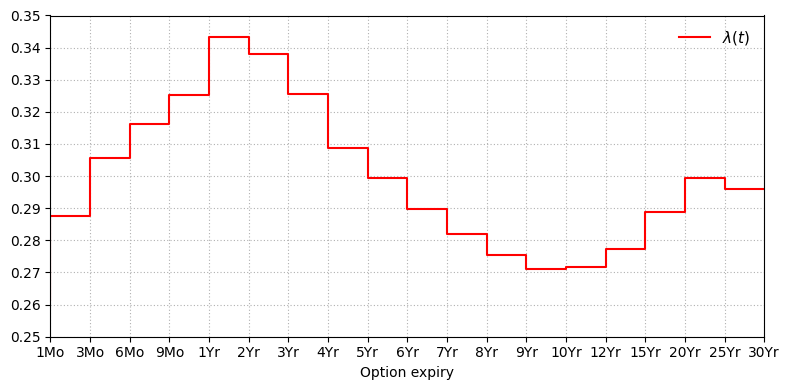

In [46]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(0.25,0.35)
ax.set_yticks(np.arange(0.25,0.36, 0.01))
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
plt.step(lambdas.index, lambdas, label = '$\\lambda(t)$', color = 'r')
plt.legend(frameon=False, loc = 'upper right', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

### Model implied volatilities

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_2 = []

for i in range(len(points)):
    lambd = lambdas[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
    IV_2.append(IV_i)

In [41]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

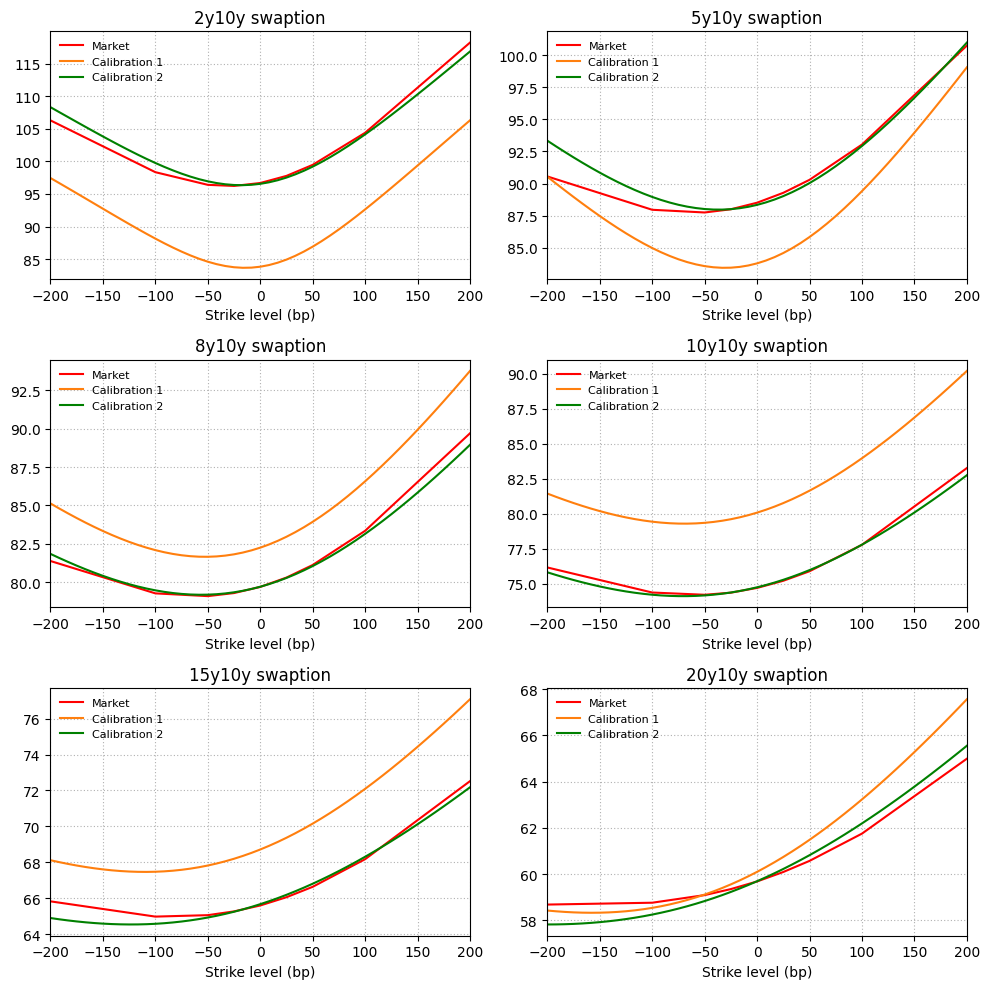

In [72]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2[0].index, IV_2[0], label = 'Calibration 2', color = 'g')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2[1].index, IV_2[1], label = 'Calibration 2', color = 'g')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2[2].index, IV_2[2], label = 'Calibration 2', color = 'g')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2[3].index, IV_2[3], label = 'Calibration 2', color = 'g')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].plot(IV_2[4].index, IV_2[4], label = 'Calibration 2', color = 'g')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].plot(IV_2[5].index, IV_2[5], label = 'Calibration 2', color = 'g')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]

IV_2_errors = []

for i in range(len(points)):

    lambd = lambdas[points[i]]
    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                        S-0/10000,
                        S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_2_errors.append(IV_i)

##### Market

In [114]:
expiries = ["3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [115]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_2_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 2']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 2"
3Mo,14.457058
6Mo,7.326291
9Mo,4.311011
1Yr,1.647811
2Yr,0.970144
3Yr,0.820517
4Yr,0.775281
5Yr,1.001282
6Yr,0.652940
7Yr,0.443614


Average root mean squared error = 1.9614759732546279


## Calibration with $\lambda(t), b(t), \eta(t)$

In [62]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strips[0].copy()
b_calibrated = price_strips[0].copy()
eta_calibrated = price_strips[0].copy()
model_prices = price_strips[0].copy()

theta = 0.379404708181496

M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    print("Expiry = ", T)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strips)): # strikes loop

        strikes_i.append(strike_strips[i].iloc[m])
        swap_rate_i.append(swaprate_strips[i].iloc[m])
        market_price_i.append(price_strips[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strips)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [14]:
lambd_calibrated = pd.Series(data = np.array([0.26566008, 0.29352139, 0.31195871, 0.32140308, 0.32648644,0.34152468, 0.33766059, 0.32362113, 0.30234794, 0.29614089, 0.28883064, 0.28287323, 0.27747187, 0.27377777, 0.27638367, 0.28256603, 0.28975099, 0.30131673, 0.29687095]), 
                             index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

b_calibrated = pd.Series(data = np.array([0.0183784 , 0.17372779, 0.1887257 , 0.19562428, 0.19653525, 0.2031521 , 0.19730479, 0.19342452, 0.19038863, 0.18365973, 0.17671099, 0.16783673, 0.15778136, 0.14615985, 0.1413279, 0.13187765, 0.11659032, 0.11282423, 0.11456432]), 
                         index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

eta_calibrated = pd.Series(data = np.array([3.09401321, 2.30990128, 1.97551876, 1.80865336, 1.59230674, 1.48578926, 1.52684785, 1.47954186, 1.32609028, 1.42419107, 1.5071296 , 1.57420393, 1.62346108, 1.65338718, 1.74639681, 1.78302146, 1.59995972, 1.66621696, 1.6197562]), 
                           index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

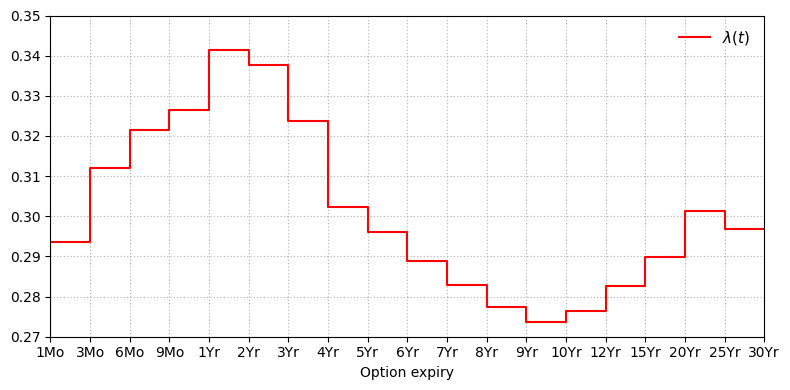

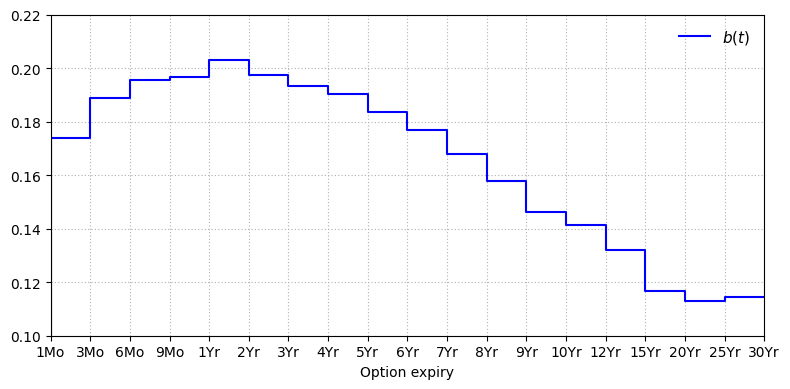

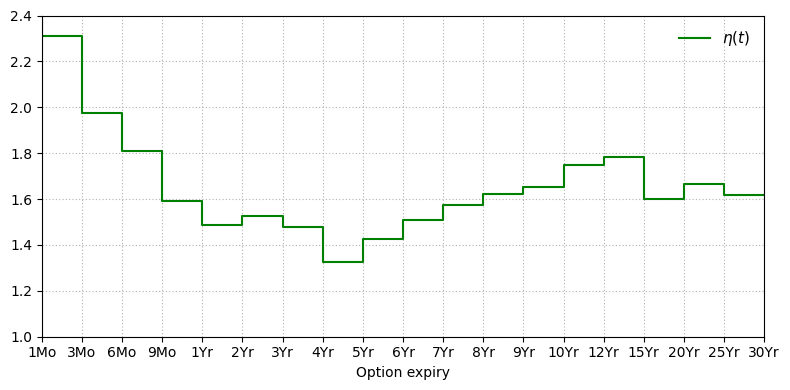

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(0.27,0.35)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
plt.step(lambd_calibrated.index, lambd_calibrated, label = '$\\lambda(t)$', color = 'r')
plt.legend(frameon=False, loc = 'upper right', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(0.1,0.22)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
plt.step(b_calibrated.index, b_calibrated, label = '$b(t)$', color = 'b')
plt.legend(frameon=False, loc = 'upper right', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(1.0,2.4)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
plt.step(eta_calibrated.index, eta_calibrated, label = '$\\eta(t)$', color = 'g')
plt.legend(frameon=False, loc = 'upper right', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

### Model implied volatilities

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_3 = []

for i in range(len(points)):
    lambd = lambd_calibrated[points[i]]
    eta = eta_calibrated[points[i]]
    b = b_calibrated[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
        
    IV_3.append(IV_i)

In [17]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [18]:
# latex_width = 6.69423 inches
w = 6.69423 * 9/10
golden_ratio = (5**.5 - 1) / 2
h = w * golden_ratio
h

3.7235355016582883

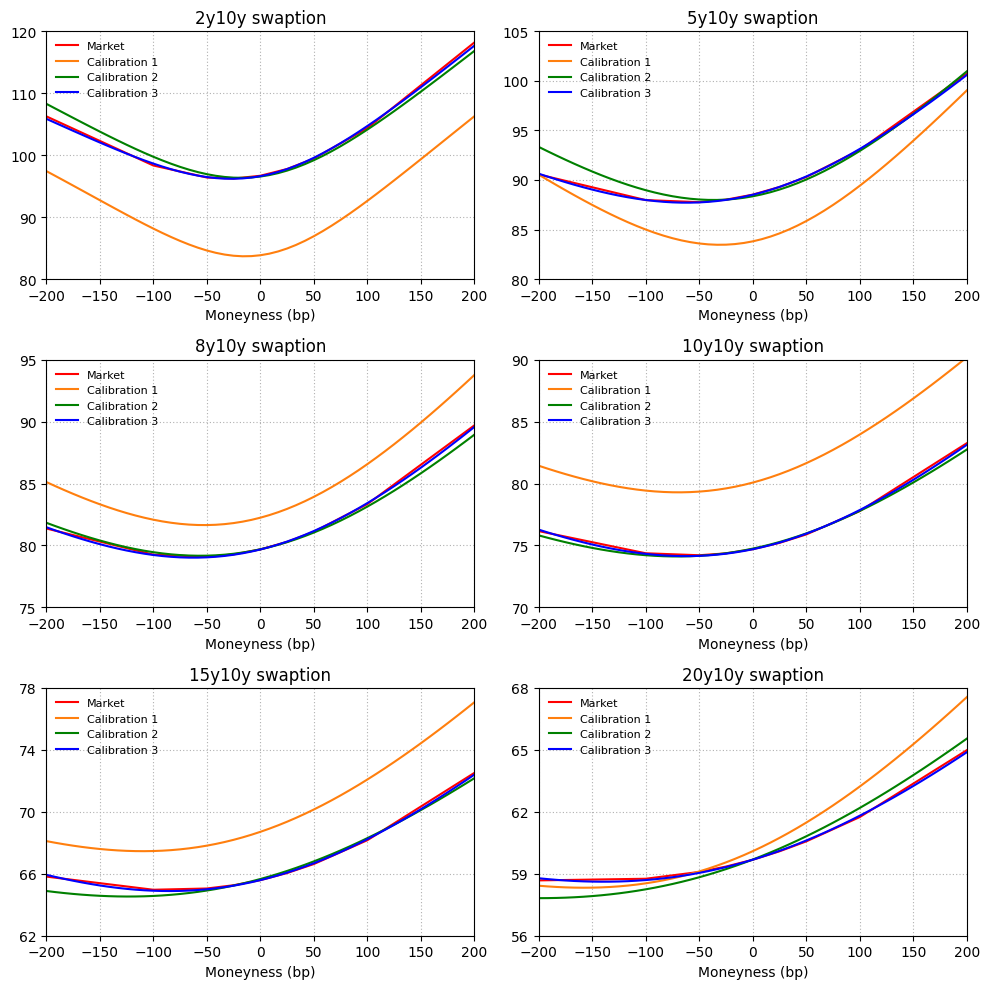

In [41]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2[0].index, IV_2[0], label = 'Calibration 2', color = 'g')
ax[0, 0].plot(IV_3[0].index, IV_3[0], label = 'Calibration 3', color = 'b')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_ylim(80,120)
ax[0, 0].set_yticks(np.arange(80,130,10))
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, loc = 'upper left', fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2[1].index, IV_2[1], label = 'Calibration 2', color = 'g')
ax[0, 1].plot(IV_3[1].index, IV_3[1], label = 'Calibration 3', color = 'b')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_ylim(80,105)
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, loc = 'upper left', fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2[2].index, IV_2[2], label = 'Calibration 2', color = 'g')
ax[1, 0].plot(IV_3[2].index, IV_3[2], label = 'Calibration 3', color = 'b')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_ylim(75,95)
ax[1, 0].set_yticks(np.arange(75,100,5))
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2[3].index, IV_2[3], label = 'Calibration 2', color = 'g')
ax[1, 1].plot(IV_3[3].index, IV_3[3], label = 'Calibration 3', color = 'b')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_ylim(70,90)
ax[1, 1].set_yticks(np.arange(70,95,5))
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].plot(IV_2[4].index, IV_2[4], label = 'Calibration 2', color = 'g')
ax[2, 0].plot(IV_3[4].index, IV_3[4], label = 'Calibration 3', color = 'b')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_ylim(62,78)
ax[2, 0].set_yticks(np.arange(62,82,4))
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].plot(IV_2[5].index, IV_2[5], label = 'Calibration 2', color = 'g')
ax[2, 1].plot(IV_3[5].index, IV_3[5], label = 'Calibration 3', color = 'b')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_ylim(56,68)
ax[2, 1].set_yticks(np.arange(56,71,3))
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]

IV_3_errors = []
theta = 0.38

for i in range(len(points)):

    lambd = lambd_calibrated[points[i]]
    b = b_calibrated[points[i]]
    eta = eta_calibrated[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                        S-0/10000,
                        S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_3_errors.append(IV_i)

##### Market

In [263]:
expiries = ["3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [264]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_3_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 3']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 3"
3Mo,6.785631
6Mo,3.548499
9Mo,2.052395
1Yr,1.114921
2Yr,0.273382
3Yr,0.138054
4Yr,0.087736
5Yr,0.065172
6Yr,0.067483
7Yr,0.065777


Average root mean squared error = 0.8179536799514643


## Weight vs no weight

In [10]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

## Calibration 1

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]

        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.0,  0.0,  0.0, 0.0,  1.0, 0.0,  0.0, 0.0,  0.0])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),(0.27, np.inf))

init_lambd = 0.25
init_b = 0.2
init_eta = 1.0
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strips))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [11]:
b =	0.4327799244994923
eta = 1.1376656823031628
theta = 0.27
lambd =	0.29174832766470093

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_1_atm = []

for i in range(len(points)):

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    # print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
        
        # print("model price", payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor))
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        # print("bach price", bachelier(S, K, res, date, T, tenor, tau_floating, t = 0))

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_1_atm.append(IV_i)

## Calibration 2

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19])

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        lambd = lambdas[m]
        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.0,  0.0,  0.0, 0.0,  1.0, 0.0,  0.0, 0.0,  0.0])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), 
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
init_lambda_5 = 0.3
init_lambda_6 = 0.3
init_lambda_7 = 0.3
init_lambda_8 = 0.3
init_lambda_9 = 0.3
init_lambda_10 = 0.3
init_lambda_11 = 0.3
init_lambda_12 = 0.3
init_lambda_13 = 0.3
init_lambda_14 = 0.3
init_lambda_15 = 0.3
init_lambda_16 = 0.3
init_lambda_17 = 0.3
init_lambda_18 = 0.3
init_lambda_19 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4, init_lambda_5, init_lambda_6, init_lambda_7, init_lambda_8, init_lambda_9, init_lambda_10, init_lambda_11, init_lambda_12, init_lambda_13, init_lambda_14, init_lambda_15, init_lambda_16, init_lambda_17, init_lambda_18, init_lambda_19]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19))
                            -np.array(price_strips))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

In [21]:
b =	0.1505909694240431
eta = 1.4997997655496471
theta = 0.39383297944656326
lambdas = pd.Series(data = np.array([0.25985149, 0.28515934, 0.30360275, 0.31435267, 0.32408323, 0.34158083, 0.33579372, 0.32330174, 0.30698261, 0.29737012, 0.28743908, 0.27962143, 0.27304904, 0.26881, 0.26938416, 0.27519312, 0.28699219, 0.29762151, 0.29444857]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_2_atm = []

for i in range(len(points)):
    lambd = lambdas[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
    IV_2_atm.append(IV_i)

## Calibration 3

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.0,  0.0,  0.0, 0.0,  1.0, 0.0,  0.0, 0.0,  0.0])

lambd_calibrated = price_strips[0].copy()
b_calibrated = price_strips[0].copy()
eta_calibrated = price_strips[0].copy()
model_prices = price_strips[0].copy()

theta = 0.379404708181496

M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    print("Expiry = ", T)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strips)): # strikes loop

        strikes_i.append(strike_strips[i].iloc[m])
        swap_rate_i.append(swaprate_strips[i].iloc[m])
        market_price_i.append(price_strips[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strips)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [15]:
lambd_calibrated_atm = pd.Series(data = np.array([0.25807904, 0.279685, 0.29300324, 0.29949785, 0.30569635, 0.31539879, 0.30810681, 0.29654128, 0.28215512, 0.27420269, 0.26599507, 0.2597174 , 0.25452169, 0.25145683, 0.25374404, 0.26170226, 0.27675355, 0.29056509, 0.29011969]), 
                             index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

eta_calibrated_atm = pd.Series(data = np.array([0.50054794, 0.50058323, 0.50112013, 0.50155324, 0.50192154, 0.5028971 , 0.50344545, 0.50372331, 0.50383439, 0.50380168, 0.50370883, 0.50357653, 0.50342721, 0.50326917, 0.50296702, 0.50260095, 0.50221403, 0.50198953, 0.50189935]), 
                         index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

b_calibrated_atm = pd.Series(data = np.array([0.50038855, 0.4999361 , 0.49987469, 0.49985163, 0.49986203, 0.49988791, 0.49975924, 0.49945934, 0.49892034, 0.49842729, 0.49778938, 0.49711794, 0.49639123, 0.49570024, 0.4948699, 0.49424115, 0.49478585, 0.49684466, 0.49810195]), 
                           index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_3_atm = []

for i in range(len(points)):
    lambd = lambd_calibrated_atm[points[i]]
    eta = eta_calibrated_atm[points[i]]
    b = b_calibrated_atm[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
        
    IV_3_atm.append(IV_i)

In [17]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

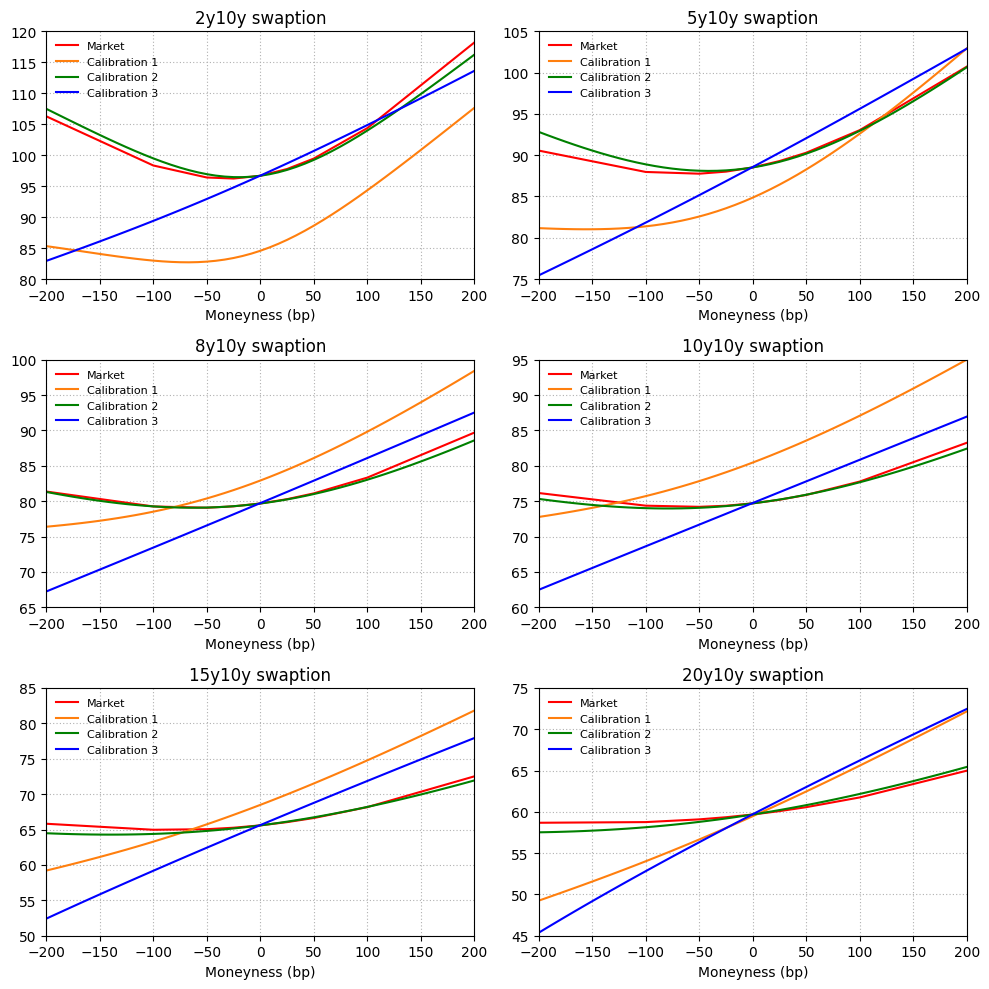

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1_atm[0].index, IV_1_atm[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2_atm[0].index, IV_2_atm[0], label = 'Calibration 2', color = 'g')
ax[0, 0].plot(IV_3_atm[0].index, IV_3_atm[0], label = 'Calibration 3', color = 'b')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_ylim(80,120)
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, loc = 'upper left', fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1_atm[1].index, IV_1_atm[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2_atm[1].index, IV_2_atm[1], label = 'Calibration 2', color = 'g')
ax[0, 1].plot(IV_3_atm[1].index, IV_3_atm[1], label = 'Calibration 3', color = 'b')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_ylim(75,105)
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, loc = 'upper left', fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1_atm[2].index, IV_1_atm[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2_atm[2].index, IV_2_atm[2], label = 'Calibration 2', color = 'g')
ax[1, 0].plot(IV_3_atm[2].index, IV_3_atm[2], label = 'Calibration 3', color = 'b')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_ylim(65,100)
ax[1, 0].set_yticks(np.arange(65,105,5))
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1_atm[3].index, IV_1_atm[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2_atm[3].index, IV_2_atm[3], label = 'Calibration 2', color = 'g')
ax[1, 1].plot(IV_3_atm[3].index, IV_3_atm[3], label = 'Calibration 3', color = 'b')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_ylim(60,95)
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1_atm[4].index, IV_1_atm[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].plot(IV_2_atm[4].index, IV_2_atm[4], label = 'Calibration 2', color = 'g')
ax[2, 0].plot(IV_3_atm[4].index, IV_3_atm[4], label = 'Calibration 3', color = 'b')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_ylim(50,85)
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1_atm[5].index, IV_1_atm[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].plot(IV_2_atm[5].index, IV_2_atm[5], label = 'Calibration 2', color = 'g')
ax[2, 1].plot(IV_3_atm[5].index, IV_3_atm[5], label = 'Calibration 3', color = 'b')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_ylim(45,75)
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()